<a href="https://colab.research.google.com/github/trekkateer/jcn6-CS-375-notebooks/blob/main/pyTorch-and-logistic-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From Linear Regression in NumPy to Logistic Regression in PyTorch

## Goals

- Compare implementing regression in NumPy vs PyTorch
- Extend regression to classification by adding softmax and cross-entropy
- Practice working with PyTorch's basic APIs

### Course Objectives Addressed

This notebook addresses the following CS 375 course objectives:

- TM-LinearLayers: "I can implement linear (fully-connected) layers using efficient parallel code."
- TM-Softmax: "I can implement softmax and explain its role in classification networks."
- OG-LossFunctions: "I can select and compute appropriate loss functions for regression and classification tasks."
- OG-ProblemFraming-Supervised: "I can frame a problem as a supervised learning task with appropriate inputs, targets, and loss function."

It will also help set you up to make progress towards the following objectives in future labs:

- TM-Implement-TrainingLoop: "I can implement a basic training loop in PyTorch."
- TM-Autograd: "I can explain the purpose of automatic differentiation and identify how it is used in PyTorch code."

This notebook ties together linear layers, softmax, and cross-entropy loss into a complete classification pipeline, bridging from NumPy to PyTorch and from regression to classification — a foundation for the multi-layer networks you'll build next.

## Setup

Let's import necessary modules: *pandas* and NumPy for data wrangling, Matplotlib for plotting, and some sklearn utilities. Now we'll also be importing PyTorch.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import scipy.optimize

# This utility function (inspired by https://github.com/HIPS/autograd/blob/master/autograd/misc/flatten.py)
# is useful for optimizing using scipy.optimize.minimize.
def flatten(arrs):
    """Return a 1D array containing the elements of the input arrays,
    and an unflatten function that takes a flattened array and returns
    the original arrays.
    """
    arrs = [np.asarray(arr) for arr in arrs]
    shapes = [arr.shape for arr in arrs]
    flat = np.concatenate([arr.ravel() for arr in arrs])
    start_indices = np.cumsum([0] + [arr.size for arr in arrs])
    def unflatten(params):
        return [params[start_indices[i]:start_indices[i+1]].reshape(shape)
                for i, shape in enumerate(shapes)]
    return flat, unflatten


We'll load the data as before.

In [2]:
ames = pd.read_csv('https://github.com/kcarnold/AmesHousing/blob/master/data/ames.csv.gz?raw=true', compression="gzip")
ames['price'] = ames["Sale_Price"] / 100_000 # Make `price` be in units of $100k, to be easier to interpret.

# Create price categories (0, 1, or 2) for the classification task
n_classes = 3
ames['price_rank'] = ames['price'].rank(pct=True)
ames['price_bin'] = pd.cut(ames['price_rank'], bins=n_classes, labels=False)

# Prepare features and target
feature_names = ['Longitude', 'Latitude']
X = ames[feature_names].values
y = ames['price_bin'].values

# standardize the features, to make the optimization more stable
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

### Basic EDA

Histogram of target values:

,count
price_bin,
0,981
1,980
2,969


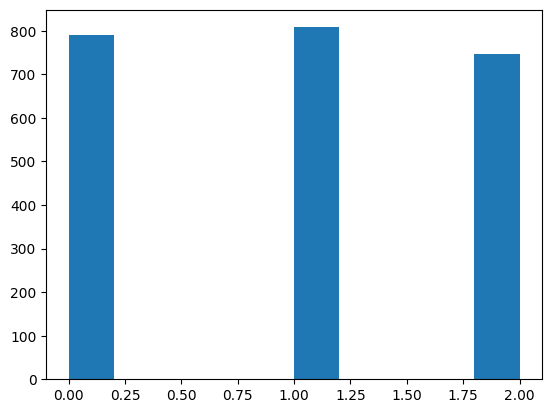

In [3]:
plt.hist(y_train);
ames['price_bin'].value_counts()

Check shapes

In [ ]:
print(f"train: X.shape={X_train.shape}, y.shape={y_train.shape}")
print(f"valid: X.shape={X_valid.shape}, y.shape={y_valid.shape}")

train: X.shape=(2344, 2), y.shape=(2344,)
valid: X.shape=(586, 2), y.shape=(586,)


Histogram of input feature values

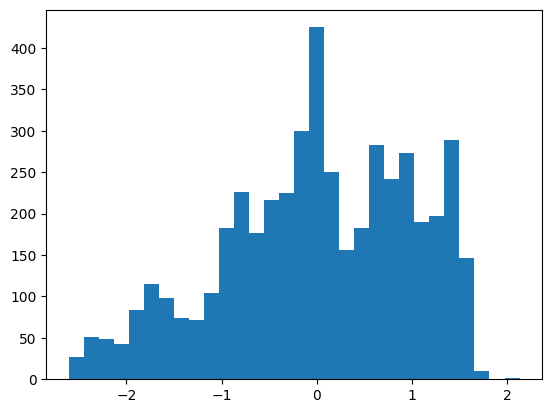

In [4]:
plt.hist(X_train.flatten(), bins=30);

## Part 1: Classification the wrong way (using linear regression)

Let's start by treating this as a regression problem - predicting the class number (0, 1, or 2) directly. We'll fit a linear regression model to the target as if it were a continuous variable. **This isn't the right way to do it**, but it will help us build up to the correct way.

### 1.A Using NumPy

You've seen the code below already. Fill in the blanks to complete the linear regression model in NumPy.

In [10]:
# Initialize parameters
np.random.seed(42)
n_samples, n_features = X_train.shape

initial_weights = np.random.standard_normal(size=n_features)
initial_bias = np.random.standard_normal()

def linear_forward(X, weights, bias):
    return X @ weights + bias

def compute_mse_loss(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

def loss_given_params(params, X, y_true):
    weights, bias = unpack_params(params)
    y_pred = linear_forward(X, weights, bias)
    return compute_mse_loss(y_true, y_pred)

initial_params, unpack_params = flatten([initial_weights, initial_bias])
initial_loss = loss_given_params(initial_params, X_train, y_train)
optimization_result = scipy.optimize.minimize(loss_given_params, initial_params,
                                              args=(X_train, y_train))
fitted_weights_np, fitted_bias_np = unpack_params(optimization_result.x)
print(f"Initial loss: {initial_loss:.2f}")
print(f"Final loss: {optimization_result.fun:.2f}")
print(f"Fitted weights: {fitted_weights_np}")
print(f"Fitted bias: {fitted_bias_np}")

Initial loss: 1.33
Final loss: 0.56
Fitted weights: [-0.26364467  0.17475394]
Fitted bias: 0.9886359247748417


Let's evaluate the "accuracy" of this model. We'll round the predictions to the nearest integer to get the predicted class.

In [11]:
y_pred_valid = linear_forward(X_valid, fitted_weights_np, fitted_bias_np).round()
y_pred_valid[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [13]:
accuracy = (y_pred_valid == y_valid).mean()
print(f"Validation accuracy for linear regression 'classifier': {accuracy:.2f}")

Validation accuracy for linear regression 'classifier': 0.31


### 1.B: Using PyTorch

Now we'll implement the same (wrong) model in PyTorch.

We'll build this together step by step. Notice that we're still doing this "the wrong way", as regression, not classification.

In [14]:
# Convert data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_valid_torch = torch.tensor(X_valid, dtype=torch.float32)
# Note: still treating as regression
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
y_valid_torch = torch.tensor(y_valid, dtype=torch.float32)

# Let's start with just learning bias terms
class SimpleLinear(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return self.bias.expand(len(x))

# TODO (together): Add weights to make it a proper linear model

# Training loop (we'll talk next week about how this works)
model = SimpleLinear(n_features)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

n_epochs = 100
for epoch in range(n_epochs):
    # Forward pass
    y_pred = model(X_train_torch)
    loss = F.mse_loss(y_pred, y_train_torch)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch:02d}, Loss: {loss.item():.4f}')

Epoch 00, Loss: 1.6177
Epoch 10, Loss: 0.6660
Epoch 20, Loss: 0.6551
Epoch 30, Loss: 0.6549
Epoch 40, Loss: 0.6549
Epoch 50, Loss: 0.6549
Epoch 60, Loss: 0.6549
Epoch 70, Loss: 0.6549
Epoch 80, Loss: 0.6549
Epoch 90, Loss: 0.6549


## Part 2: Converting to Classification

Now we're going to switch to doing it the right way, as a classification problem. We'll use the softmax function to convert the model's outputs into probabilities, and the cross-entropy loss to train the model to be least surprised by the true class.

Again we'll start off by implementing this in NumPy, and then extend it to PyTorch.

### 2.A Using NumPy (we'll do this together)

Let's modify our NumPy implementation to:

1. Output one number per class (logits)
2. Convert logits to probabilities using softmax
3. Use cross-entropy loss instead of MSE

We'll start by using one-hot encoding for the outputs, which will make it easy to implement the cross-entropy loss.

In [15]:
# np.eye is the identity matrix; each row is a one-hot vector.
# this code pulls out the one-hot vectors corresponding to the target values
y_train_onehot = np.eye(n_classes)[y_train]
y_valid_onehot = np.eye(n_classes)[y_valid]

y_train_onehot[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

Now we'll implement softmax and cross-entropy together.

In [29]:
def softmax(logits):
    """Convert logits to probabilities."""
    num_samples, num_classes = logits.shape

    max_logit = logits.max(axis=1, keepdims=True)

    exp_logits = logits.exp()
    assert exp_logits.shape == (num_samples, num_classes)

    sum_exp_logits = exp_logits.sum(axis=1, keepdims=True)
    assert sum_exp_logits.shape == (num_samples, 1)
    return exp_logits/sum_exp_logits

def cross_entropy_loss(y_true_onehot, probs):
    """Compute cross entropy loss."""
    # Strategy:
    # - Compute log probabilities
    # - Multiply by one-hot vectors and sum, to extract the log probabilities of the true classes
    # - Take the negative to get the loss
    # - Average the loss over the samples
    #
    log_probs = np.log(probs + 1e-6) # add a small value to avoid log(0)
    loss_per_sample = -np.sum(y_true_onehot * log_probs, axis=1)
    assert loss_per_sample.shape == (len(y_true_onehot),)
    return loss_per_sample.mean()


In [ ]:
# copy and paste the NumPy code block here and we'll edit.
# your code here



Initial loss: 1.93
Final loss: 1.02
Fitted weights: [[ 0.7753546   0.39962183 -0.16883813]
 [ 0.01584829  0.34061106  0.69827992]]
Fitted bias: [0.61377123 0.75167041 0.51173135]


Now let's compute the accuracy again.

In [ ]:
y_pred_valid_logits = linear_forward(X_valid, fitted_weights_np, fitted_bias_np)
y_pred_valid = y_pred_valid_logits.argmax(axis=1)
y_pred_valid[:10]

array([0, 1, 2, 2, 0, 2, 0, 1, 2, 2])

In [ ]:
accuracy = (y_pred_valid == y_valid).mean()
print(f"Validation accuracy for logistic regression: {accuracy:.2f}")

Validation accuracy for logistic regression: 0.52


### 2.B Using PyTorch

We'll first walk through the PyTorch primitives together, then you'll modify the PyTorch code from Part 1 to use these primitives.

In [ ]:
y_train_longtensor = torch.tensor(y_train)
y_valid_longtensor = torch.tensor(y_valid)

#### Setting up the linear layer

Fill in the blanks below with the correct number of features.

In [ ]:
linear_layer = nn.Linear(in_features=..., out_features=..., bias=True)
logits = linear_layer(X_train_torch)
logits.shape

torch.Size([2344, 3])

#### Softmax

PyTorch has builtin functionality for softmax. We can use it like this:

In [ ]:
probs = logits.softmax(axis=1)
probs.shape

torch.Size([2344, 3])

Let's check that the probabilities sum to 1 for each row. Think about what axis you should use for the sum. *General sum rule: whatever axis we sum over will be the axis that disappears.*

In [ ]:
probs_sums = probs.sum(axis=...)
probs_sums.shape

torch.Size([2344])

In [ ]:
probs_sums[:10]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], grad_fn=<SliceBackward0>)

#### Cross-entropy loss

There are a few different ways we could implement a categorical cross-entropy loss in PyTorch; notice that they give the same output. The `F.cross_entropy` approach is most efficient and numerically stable because **it combines the softmax operation, one-hot encoding, and the cross-entropy loss** into a single step.

In [ ]:
# Direct approach, analogous to the NumPy code above
y_train_onehot_torch = torch.tensor(y_train_onehot, dtype=torch.int64)
log_probs = probs.log()
-(y_train_onehot_torch * log_probs).sum(axis=1).mean()

tensor(1.1906, grad_fn=<NegBackward0>)

In [ ]:
# cross-entropy loss function in PyTorch uses logits (without softmax) and class indices (without one-hot)
F.cross_entropy(logits, y_train_longtensor)

tensor(1.1906, grad_fn=<NllLossBackward0>)

<details>
  <summary>Other ways to compute cross-entropy loss</summary>

```python
 # see also F.one_hot if you're curious.
F.nll_loss(log_probs, y_train_longtensor)
F.nll_loss(logits.log_softmax(axis=1), y_train_longtensor)

# using the "object-oriented" interface
loss_fn = nn.CrossEntropyLoss()
loss_fn(logits, y_train_longtensor)
```
</details>

#### Full PyTorch Implementation

**Your turn**: Copy and paste your PyTorch linear regression code here and make it into a logistic regression by modifying it to use softmax and cross-entropy loss.


In [ ]:
# your code here

Epoch 00, Loss: 1.3116
Epoch 10, Loss: 1.1680
Epoch 20, Loss: 1.0995


Epoch 30, Loss: 1.0654
Epoch 40, Loss: 1.0468
Epoch 50, Loss: 1.0359
Epoch 60, Loss: 1.0292
Epoch 70, Loss: 1.0249
Epoch 80, Loss: 1.0220
Epoch 90, Loss: 1.0202


### Looking ahead: a multi-layer network

Just as a preview for where we're going next week:

In [ ]:
n_hidden = 100
model = nn.Sequential(
    nn.Linear(in_features=n_features, out_features=n_hidden, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=n_hidden, out_features=n_classes, bias=True),
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

n_epochs = 1000
for epoch in range(n_epochs):
    # Forward pass
    logits = model(X_train_torch)
    loss = F.cross_entropy(logits, y_train_longtensor)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss.item():.4f}')

# Evaluate on validation set
logits_valid = model(X_valid_torch)
y_pred_valid = logits_valid.argmax(dim=1)
accuracy = (y_pred_valid == y_valid_longtensor).float().mean()
print(f'Validation accuracy: {accuracy.item():.2f}')

Epoch 000, Loss: 1.1152
Epoch 010, Loss: 1.0143
Epoch 020, Loss: 0.9913
Epoch 030, Loss: 0.9761
Epoch 040, Loss: 0.9638
Epoch 050, Loss: 0.9535
Epoch 060, Loss: 0.9446
Epoch 070, Loss: 0.9369
Epoch 080, Loss: 0.9301
Epoch 090, Loss: 0.9240
Epoch 100, Loss: 0.9187
Epoch 110, Loss: 0.9141
Epoch 120, Loss: 0.9099
Epoch 130, Loss: 0.9063
Epoch 140, Loss: 0.9030
Epoch 150, Loss: 0.9001
Epoch 160, Loss: 0.8974
Epoch 170, Loss: 0.8951
Epoch 180, Loss: 0.8929
Epoch 190, Loss: 0.8909
Epoch 200, Loss: 0.8891
Epoch 210, Loss: 0.8875
Epoch 220, Loss: 0.8859
Epoch 230, Loss: 0.8845
Epoch 240, Loss: 0.8832
Epoch 250, Loss: 0.8819
Epoch 260, Loss: 0.8807
Epoch 270, Loss: 0.8795
Epoch 280, Loss: 0.8785
Epoch 290, Loss: 0.8774
Epoch 300, Loss: 0.8765
Epoch 310, Loss: 0.8755
Epoch 320, Loss: 0.8746
Epoch 330, Loss: 0.8737
Epoch 340, Loss: 0.8728
Epoch 350, Loss: 0.8720
Epoch 360, Loss: 0.8712
Epoch 370, Loss: 0.8704
Epoch 380, Loss: 0.8696
Epoch 390, Loss: 0.8688
Epoch 400, Loss: 0.8681
Epoch 410, Loss:

## Analysis

Come back to these questions after you've finished the lab.

1. Compare the NumPy and PyTorch implementations. What are the main differences you notice? What are the benefits of PyTorch?

2. We came up with 4 weight matrices in the main part of this exercise (linear regression NumPy and PyTorch, logistic regression NumPy and PyTorch). Which of these matrices had the same shapes? Which ones had the same values? Why?

3. Which of these two models (linear regression vs logistic regression) does better on this task? (Which number would we use to compare them: loss, accuracy, or something else? Why?)

4. Suppose a job interviewer asks you to describe the similarities and differences between linear regression and logistic regression. What would you say? (Hint: discuss how each model makes a prediction, what kinds of patterns in the data they can use, how you measure training progress, etc.

*your thoughtful answers here*